In [1]:
#B.Pagli 04/2023
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from CRO import RO_solver, RO_par_load
from CRO import RO_fitting
from math import floor

In [2]:
#Call RO_solver with parameters of interest

#[-0.02,0.2,1.1]
#5pi/4 is converted to its principal value in [-pi;pi] as np.arctan2 from fit will return an angle in this quadrant

par = {'R': [-0.08,0.1, (5*np.pi/4 + np.pi) % (2*np.pi) - np.pi],
   'F1': 0.02,
   'F2': 0.9,
   'epsilon': 0.03,
   'b_T': 0.03,
   'c_T': 0.1,
   'd_T': 0.005,
   'b_h': 0.1,
   'sigma_T': 0.2,
   'sigma_h': 1.2,
   'B': 0.5,
   'm_T': 2.0,
   'm_h': 2.0,
   'n_T': 0,
   'n_h': 0,
   'n_g': 0}


IC = [0.02,0.05] #Initial condition, arbitrary choice here
N = 100*12 #Lenght of the time series in month
NE = 1 #NB of members to generate
EF = {'E_T':0.0,'E_h':0.0} #External forcing, null here.
NM='EH' # numerical scheme
dt=0.1 #dt used in RO solver in month
saveat=1. #save every saveat month, needs to be an integer multiple of dt

#Specify custom noises in noise_custom
t_tot = np.array([j*dt for j in range(floor((N-1)/dt)+1)])
w_T=np.random.normal(0, 1, size = t_tot.size)
w_h=np.random.normal(0, 1, size = t_tot.size)
w_xi_T=np.random.normal(0, 1, size = t_tot.size)
w_xi_h=np.random.normal(0, 1, size = t_tot.size)

noise_custom=[w_T,w_h,w_xi_T,w_xi_h]

t=t_tot[::int(round(saveat / dt))]



#Call the RO solver function, the set of parameters par, and the different arguments
#This returns an ensemble of NE members of T,h and the white noises used in the time integration of dT/dt and dh/dt dxi_T/dt, dxi_h/dt
T,h,_ = RO_solver(par=par,IC=IC,N=N,NE=NE,EF=EF,NM=NM,dt=dt,saveat=saveat,noise_custom=noise_custom)




Sample 1/1


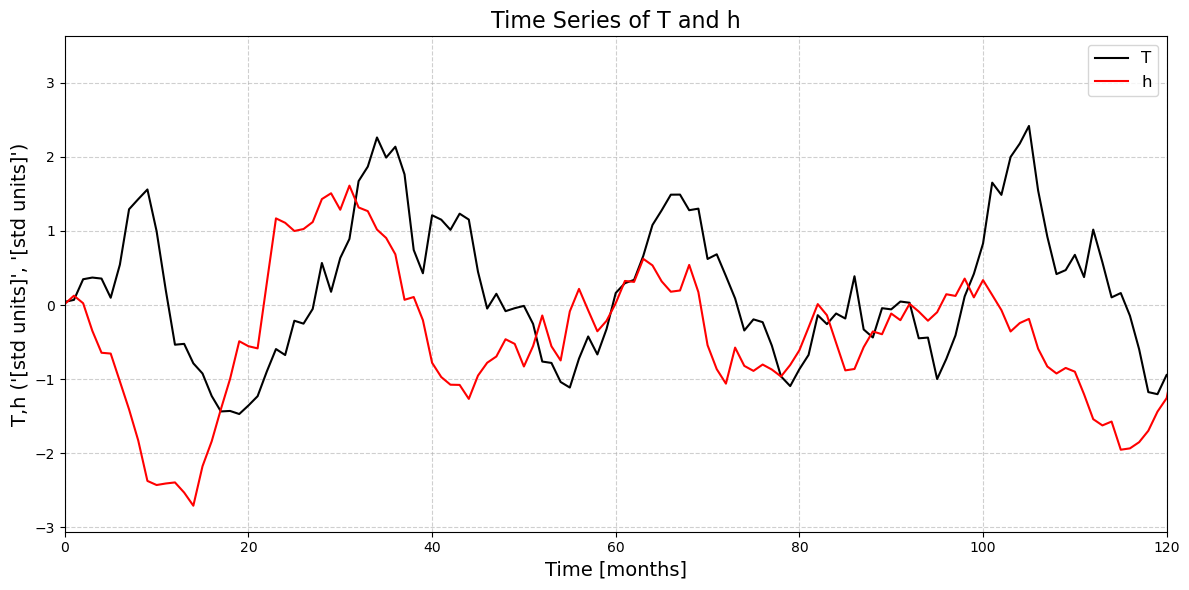

In [3]:
#plot for one member of the synthetic RO ensemble the phase space and T,h time series
normalized=True
idx_ens=0
if normalized:
    unit_T = '[std units]'
    unit_h = '[std units]'
    T_idx = T[idx_ens]/(np.std(T[idx_ens]))
    h_idx =  h[idx_ens]/(np.std(h[idx_ens]))
else:
    unit_T = '[K]'
    unit_h = '[m]'
    T_idx = T[idx_ens]
    h_idx =  h[idx_ens]

fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(t, T_idx, 'k', linewidth=1.5, label='T')
ax1.plot(t, h_idx, 'r', linewidth=1.5, label='h')

ax1.set_xlabel('Time [months]', fontsize=14)
ax1.set_ylabel(f'T,h {unit_T,unit_h}', fontsize=14)
ax1.legend(fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.set_title('Time Series of T and h', fontsize=16)
ax1.set_xlim(0,120)


plt.tight_layout()

In [4]:
#Initialize and run the fit
method_fitting='LR-F'
dt_fitting=1.0
T_to_fit = T[idx_ens]
h_to_fit = h[idx_ens]
T_option={'R':3, 'F1': 1, 'b_T': 1, 'c_T': 1, 'd_T': 1} 

h_option={'F2': 1, 'epsilon': 1, 'b_h': 1} 

noise_option={'T': "red", 'h': "red", 'T_type': "multi"} 

fitted_param = RO_fitting(T=T_to_fit,h=h_to_fit,T_option=T_option, h_option=h_option, noise_option=noise_option, method_fitting=method_fitting,dt_fitting=1.0,)


Fit Sample 1/1


In [5]:
fitted_param

{'R': [-0.044565508797397436, 0.10931375947483885, -1.8513301674560096],
 'F1': 0.01611542065795611,
 'b_T': 0.0347463384681044,
 'c_T': 0.056468294384799014,
 'd_T': 0.005339600214255999,
 'F2': 0.8341384195541177,
 'epsilon': 0.02824755876347211,
 'b_h': -0.02955972480580131,
 'sigma_T': 0.14181621188303328,
 'sigma_h': 0.8906683118399862,
 'B': 0.5816780917282324,
 'm_T': 0.744418631056407,
 'm_h': 0.7475500929555153,
 'n_T': 0,
 'n_h': 0,
 'n_g': 0}

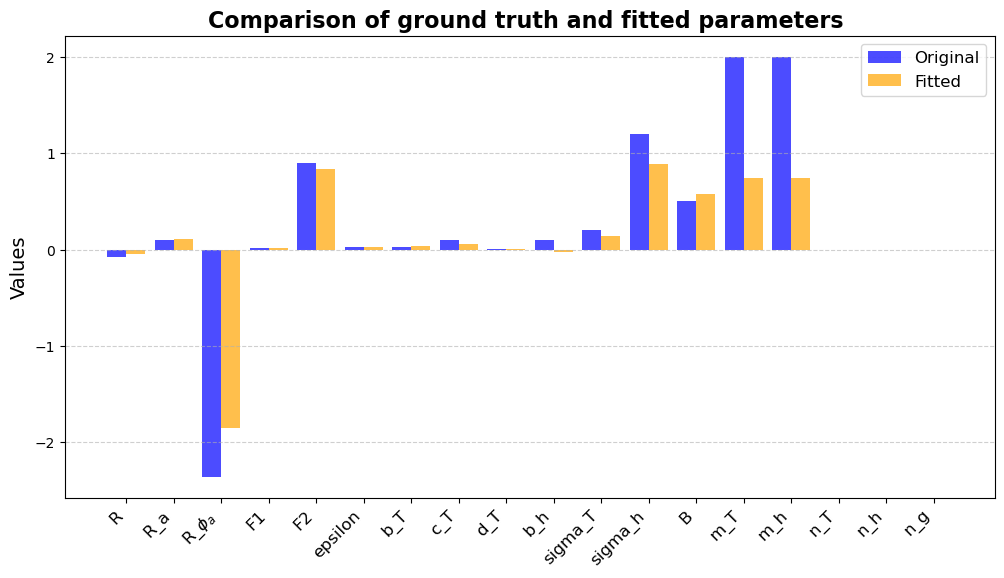

In [6]:
#Visualize the estimated parameters and the ground truth parameters

# Function to flatten dictionary, expanding list values
def flatten_dict(d):
    flat_dict = {}
    for key, value in d.items():
        if isinstance(value, list):  # If the value is a list, expand it
            subscript = ['','_a','_$\\phi_a$']
            for i, val in enumerate(value):
                flat_dict[f"{key}{subscript[i]}"] = val  # Create new keys like R_1, R_2, etc.
        else:
            flat_dict[key] = value  # Keep scalar values as they are
    return flat_dict

# Flatten both dictionaries
flat_dict1 = flatten_dict(par)
flat_dict2 = flatten_dict(fitted_param)

df = pd.DataFrame({'Source': flat_dict1, 'Fitted': flat_dict2})

# Replace NaN with 0 (optional: you can drop NaN instead)
df = df.fillna(0)

# Plot settings
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.4
indices = np.arange(len(df))

# Plot bars
ax.bar(indices - bar_width/2, df['Source'], bar_width, label='Original', color='blue', alpha=0.7)
ax.bar(indices + bar_width/2, df['Fitted'], bar_width, label='Fitted', color='orange', alpha=0.7)

# Labels & Formatting
ax.set_xticks(indices)
ax.set_xticklabels(df.index, rotation=45, ha='right', fontsize=12)
ax.set_ylabel('Values', fontsize=14)
ax.set_title('Comparison of ground truth and fitted parameters ', fontsize=16, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.6)

# Show the plot
plt.show()

In [7]:
#We regenerate T and h with the fitted parameters 
T_regen,h_regen,_ = RO_solver(par=fitted_param,IC=IC,N=N,NE=NE,EF=EF,NM=NM,dt=dt,saveat=saveat,noise_custom=noise_custom)



Sample 1/1


Text(0.5, 1.0, 'Time Series of T and h')

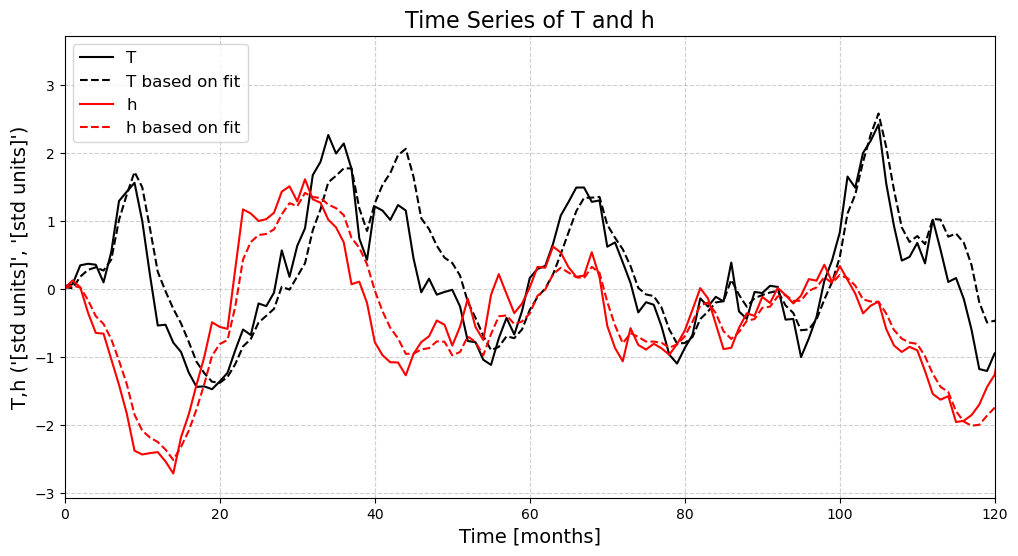

In [8]:
#And compare it with ground truth time series. The same noises are used 
#for both integration of RO equations in RO_Solver (cf. custom noise)
normalized=True
idx_ens=0
if normalized:
    unit_T = '[std units]'
    unit_h = '[std units]'
    T_idx_regen = T_regen[idx_ens]/(np.std(T_regen[idx_ens]))
    h_idx_regen =  h_regen[idx_ens]/(np.std(h_regen[idx_ens]))
else:
    unit_T = '[K]'
    unit_h = '[m]'
    T_idx = T[idx_ens]
    h_idx =  h[idx_ens]

fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(t, T_idx, 'k', linewidth=1.5, label='T')
ax1.plot(t, T_idx_regen, 'k', linewidth=1.5, label='T based on fit', linestyle='--')
ax1.plot(t, h_idx, 'r', linewidth=1.5, label='h')
ax1.plot(t, h_idx_regen, 'r', linewidth=1.5, label='h based on fit', linestyle='--')

ax1.set_xlabel('Time [months]', fontsize=14)
ax1.set_xlim(0,120)
ax1.set_ylabel(f'T,h {unit_T,unit_h}', fontsize=14)
ax1.legend(fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.set_title('Time Series of T and h', fontsize=16)